<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import re
import shutil
import string
import warnings

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [4]:
# Import des données
link = 'https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv'
data = pd.read_csv(link, encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Comptage des spams et des non-spams (pour voir la fréquence des spams dans le dataset)
data['v1'].value_counts()

,count
v1,
ham,4825
spam,747


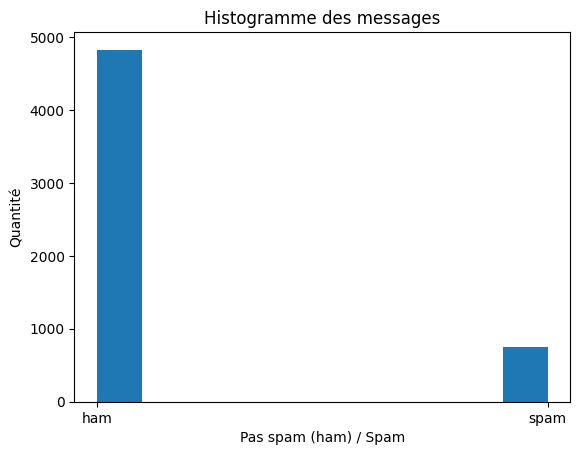

In [6]:
# Histogramme pour visualiser la fréquence des spams
plt.hist(data['v1'])
plt.title('Histogramme des messages')
plt.xlabel('Pas spam (ham) / Spam')
plt.ylabel('Quantité')
plt.show()

In [7]:
data.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
data[data.iloc[:,4].isna() == False]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""
5048,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""


## Preprocessing

In [10]:
sms_data = data.copy()

# On assemble tout le message dans la même colonne
for i in [2, 3, 4]:
  sms_data.loc[sms_data.iloc[:,i].isna() == False,'v2'] += ' '+sms_data.loc[sms_data.iloc[:,i].isna() == False,'Unnamed: '+str(i)]

sms_data = sms_data[['v2', 'v1']].rename(columns = {'v2': 'message', 'v1': 'target'})
sms_data.head()

,message,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [11]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 28.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
import en_core_web_md
nlp = en_core_web_md.load()
from spacy.lang.en.stop_words import STOP_WORDS

In [13]:
# Nettoyage du message en retirant la ponctuation et les stop words
sms_data["message_clean"] = sms_data["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
sms_data["message_clean"] = sms_data["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
sms_data["message_clean"] = sms_data["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

sms_data.head()

,message,target,message_clean
0,"Go until jurong point, crazy.. Available only ...",ham,jurong point crazy available bugis n great wor...
1,Ok lar... Joking wif u oni...,ham,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,ham,u dun early hor u c
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah think usf live


In [14]:
# Encodage du message et de la target
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(sms_data.message_clean)
sms_data["message_encoded"] = tokenizer.texts_to_sequences(sms_data.message_clean)

def is_spam(message):
  if(message=='spam'):
    return 1
  else:
    return 0

sms_data["target_encoded"] = sms_data.target.apply(is_spam)

sms_data.head()

,message,target,message_clean,message_encoded,target_encoded
0,"Go until jurong point, crazy.. Available only ...",ham,jurong point crazy available bugis n great wor...,"[1, 235, 448, 463, 943, 32, 51, 209, 944, 78, ...",0
1,Ok lar... Joking wif u oni...,ham,ok lar joke wif u oni,"[9, 196, 464, 291, 2, 1]",0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 302, 3, 531, 660, 30, 1, 850, 425, 1, 1, ...",1
3,U dun say so early hor... U c already then say...,ham,u dun early hor u c,"[2, 126, 150, 1, 2, 80]",0
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah think usf live,"[708, 20, 661, 131]",0


In [15]:
# Récupération de 3 spams et 3 hams pour le test final
test_indices = [5547, 5566, 5567, 5569, 5570, 5571]
sms_train = sms_data.drop(test_indices)
sms_test = sms_data.iloc[test_indices, :]
print('sms_train :')
display(sms_train)
print()
print('sms_test :')
display(sms_test)

sms_train :


,message,target,message_clean,message_encoded,target_encoded
0,"Go until jurong point, crazy.. Available only ...",ham,jurong point crazy available bugis n great wor...,"[1, 235, 448, 463, 943, 32, 51, 209, 944, 78, ...",0
1,Ok lar... Joking wif u oni...,ham,ok lar joke wif u oni,"[9, 196, 464, 291, 2, 1]",0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 302, 3, 531, 660, 30, 1, 850, 425, 1, 1, ...",1
3,U dun say so early hor... U c already then say...,ham,u dun early hor u c,"[2, 126, 150, 1, 2, 80]",0
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah think usf live,"[708, 20, 661, 131]",0
...,...,...,...,...,...
5562,Ok lor... Sony ericsson salesman... I ask shuh...,ham,ok lor sony ericsson salesman ask shuhui gd 2 ...,"[9, 24, 781, 1, 1, 40, 1, 498, 3, 161, 1]",0
5563,Ard 6 like dat lor.,ham,ard 6 like dat lor,"[373, 229, 13, 186, 24]",0
5564,Why don't you wait 'til at least wednesday to ...,ham,wait ' til wednesday,"[49, 87, 323, 936]",0
5565,Huh y lei...,ham,huh y lei,"[402, 158, 358]",0



sms_test :


,message,target,message_clean,message_encoded,target_encoded
5547,Had your contract mobile 11 Mnths? Latest Moto...,spam,contract mobile 11 mnth late motorola nokia et...,"[1, 31, 770, 1, 67, 583, 104, 562, 11, 347, 84...",1
5566,REMINDER FROM O2: To get 2.50 pounds free call...,spam,reminder o2 250 pound free credit detail great...,"[1, 1, 1, 282, 11, 293, 300, 51, 152, 58, 26, ...",1
5567,This is the 2nd time we have tried 2 contact u...,spam,2nd time try 2 contact u u win å750 pound priz...,"[270, 16, 46, 3, 93, 2, 2, 30, 1, 282, 68, 3, ...",1
5569,"Pity, * was in mood for that. So...any other s...",ham,pity mood soany suggestion,"[1, 939, 1, 1]",0
5570,The guy did some bitching but I acted like i'd...,ham,guy bitching act like interested buy week free,"[114, 1, 1, 13, 1, 86, 35, 11]",0
5571,Rofl. Its true to its name,ham,rofl true,"[1, 314]",0


In [16]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(sms_train.message_encoded, padding="post")

In [17]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(sms_test.message_encoded, padding="post")

In [18]:
xtrain, xval, ytrain, yval = train_test_split(train_pad, sms_train.target_encoded, test_size=0.3)

In [19]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [20]:
test_pad

array([[  1,  31, 770,   1,  67, 583, 104, 562,  11, 347,  84,  18, 267,
          1,  18,  75,   1, 637, 802],
       [  1,   1,   1, 282,  11, 293, 300,  51, 152,  58,  26,   3,  18,
        343, 216,   1,   0,   0,   0],
       [270,  16,  46,   3,  93,   2,   2,  30,   1, 282,  68,   3,  47,
        219,   1,   1, 542, 141, 935],
       [  1, 939,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [114,   1,   1,  13,   1,  86,  35,  11,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  1, 314,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]], dtype=int32)

In [26]:
sms_test.target

,target
5547,spam
5566,spam
5567,spam
5569,ham
5570,ham
5571,ham


In [28]:
test = tf.data.Dataset.from_tensor_slices((test_pad, sms_test.target))

In [29]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [30]:
for message, target in train_batch.take(1):
  print(message, target)

tf.Tensor(
[[  7 180 349 ...   0   0   0]
 [  1   1  90 ...   0   0   0]
 [ 16  19  63 ...   0   0   0]
 ...
 [ 75   1 246 ...   0   0   0]
 [742  75  56 ...   0   0   0]
 [ 72  33  69 ...   0   0   0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0], shape=(64,), dtype=int64)


## Modèle


- Partir d'un modèle simple https://app.jedha.co/course/introduction-to-tensorflow-ft/tensorflow-playground-with-code-ft
- Tester des plus complexes par la suite :
  - Embedding
  - Recurrent NN


In [31]:
model_simple = Sequential([
    # Couche Dense classique
    Dense(8, activation='relu', input_shape=[message.shape[1],]),
    # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
    Dense(1, activation='sigmoid')
])

model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
opt1 = tf.keras.optimizers.Adam(name = 'Adam')
bce1 = tf.keras.losses.BinaryCrossentropy()
precision1 = tf.keras.metrics.Precision(name = 'precision')
recall1 = tf.keras.metrics.Recall(name = 'recall')
auc1 = tf.keras.metrics.AUC(name = 'auc')

In [33]:
model_simple.compile(optimizer=opt1,
                    loss=bce1,
                    metrics=['accuracy',
                             precision1,
                             recall1,
                             auc1])

In [34]:
history_simple = model_simple.fit(train_batch,
                                epochs=50,
                                validation_data=val_batch)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6223 - auc: 0.5977 - loss: 15.5578 - precision: 0.1891 - recall: 0.5616 - val_accuracy: 0.6922 - val_auc: 0.5515 - val_loss: 9.3564 - val_precision: 0.1951 - val_recall: 0.3682
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7122 - auc: 0.6035 - loss: 7.7789 - precision: 0.2121 - recall: 0.4324 - val_accuracy: 0.7383 - val_auc: 0.5862 - val_loss: 5.2743 - val_precision: 0.2203 - val_recall: 0.3264
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7734 - auc: 0.6457 - loss: 4.2751 - precision: 0.2563 - recall: 0.3858 - val_accuracy: 0.8006 - val_auc: 0.6593 - val_loss: 3.3015 - val_precision: 0.2920 - val_recall: 0.2762
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8279 - auc: 0.6923 - loss: 2.7906 - precision: 0.3325 - recall: 0.3361 - val_accuracy: 0.8144 - val_auc: 0.6924 - val_loss: 2.4617 - val_precision: 0.3216 - val_recall: 0.2678
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
vocab_size = tokenizer.num_words

model_embed = Sequential([
    Embedding(vocab_size+1, 8, input_shape=[message.shape[1],], name="embedding"),
    # Gobal average pooling
    GlobalAveragePooling1D(),
    # Couche Dense classique
    Dense(16, activation='relu'),
    # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
    Dense(1, activation='sigmoid')
])

model_embed.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 74, 8)               │           8,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,169 (31.91 KB)

 Trainable params: 8,169 (31.91 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
opt2 = tf.keras.optimizers.Adam(name = 'Adam_embed')
bce2 = tf.keras.losses.BinaryCrossentropy()
precision2 = tf.keras.metrics.Precision(name = 'precision_embed')
recall2 = tf.keras.metrics.Recall(name = 'recall_embed')
auc2 = tf.keras.metrics.AUC(name = 'auc_embed')

In [37]:
model_embed.compile(optimizer=opt2,
                    loss=bce2,
                    metrics=['accuracy',
                             precision2,
                             recall2,
                             auc2])

In [38]:
history_embed = model_embed.fit(train_batch,
                                epochs=50,
                                validation_data=val_batch)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8201 - auc_embed: 0.5623 - loss: 0.5272 - precision_embed: 0.2188 - recall_embed: 0.1085 - val_accuracy: 0.8569 - val_auc_embed: 0.9010 - val_loss: 0.3866 - val_precision_embed: 0.0000e+00 - val_recall_embed: 0.0000e+00
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - auc_embed: 0.8951 - loss: 0.3573 - precision_embed: 0.0000e+00 - recall_embed: 0.0000e+00 - val_accuracy: 0.8569 - val_auc_embed: 0.9114 - val_loss: 0.3790 - val_precision_embed: 0.0000e+00 - val_recall_embed: 0.0000e+00
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - auc_embed: 0.8879 - loss: 0.3660 - precision_embed: 0.0000e+00 - recall_embed: 0.0000e+00 - val_accuracy: 0.8569 - val_auc_embed: 0.9147 - val_loss: 0.3756 - val_precision_embed: 0.0000e+00 - val_recall_embed: 0.0000e+00
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 - auc_embed: 0.9013 - loss: 0.3376 - precision_embed: 0.0000e+

## Evaluation

### Modèle simple

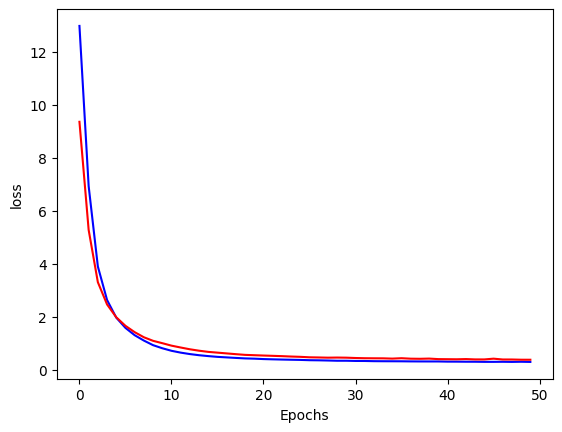

In [39]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_simple.history["loss"], color="b")
plt.plot(history_simple.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

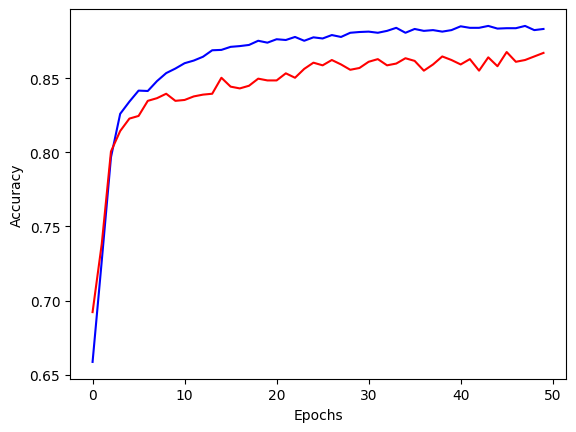

In [40]:
plt.plot(history_simple.history["accuracy"], color="b")
plt.plot(history_simple.history["val_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

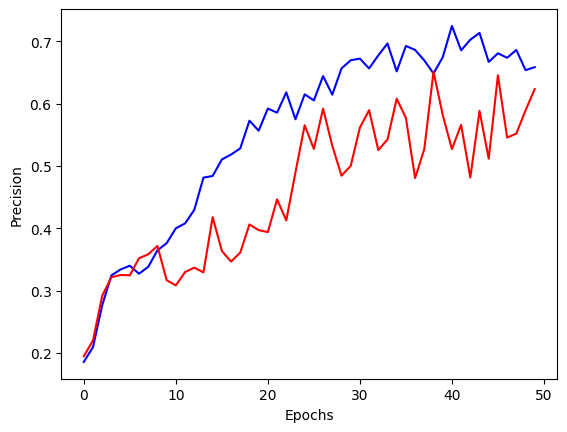

In [41]:
plt.plot(history_simple.history["precision"], color="b")
plt.plot(history_simple.history["val_precision"], color="r")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.show()

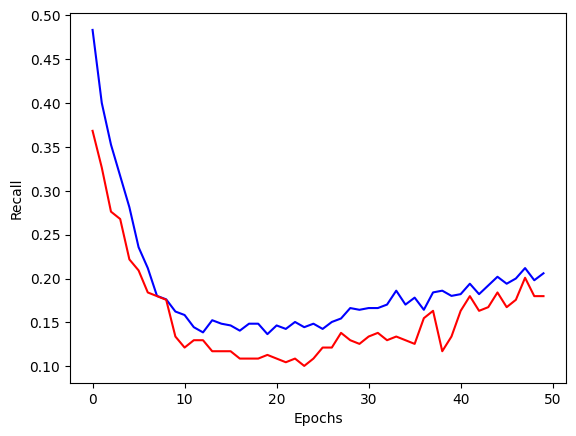

In [42]:
plt.plot(history_simple.history["recall"], color="b")
plt.plot(history_simple.history["val_recall"], color="r")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.show()

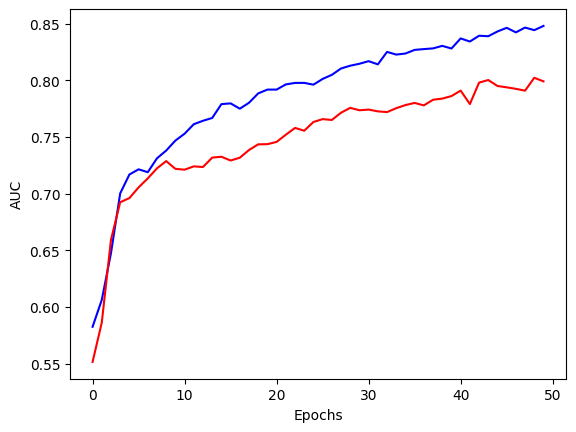

In [43]:
plt.plot(history_simple.history["auc"], color="b")
plt.plot(history_simple.history["val_auc"], color="r")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.show()

### Modèle Embedding

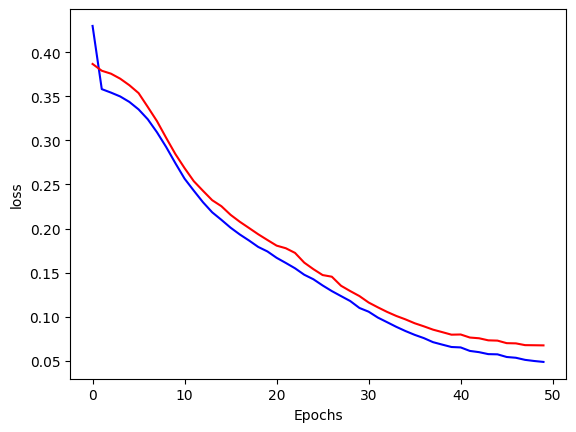

In [44]:
import matplotlib.pyplot as plt

# Visualisation de l'entraînement sur la fonction loss
plt.plot(history_embed.history["loss"], color="b")
plt.plot(history_embed.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

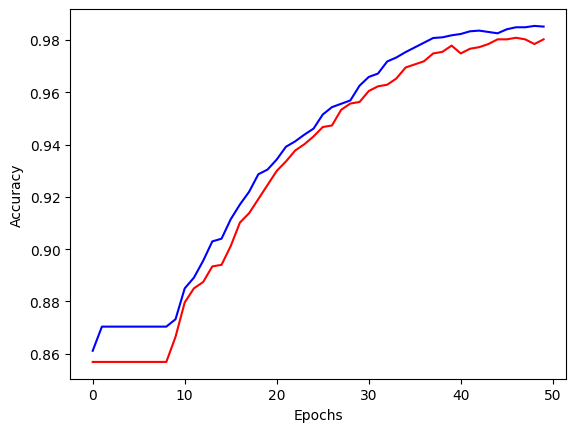

In [45]:
plt.plot(history_embed.history["accuracy"], color="b")
plt.plot(history_embed.history["val_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

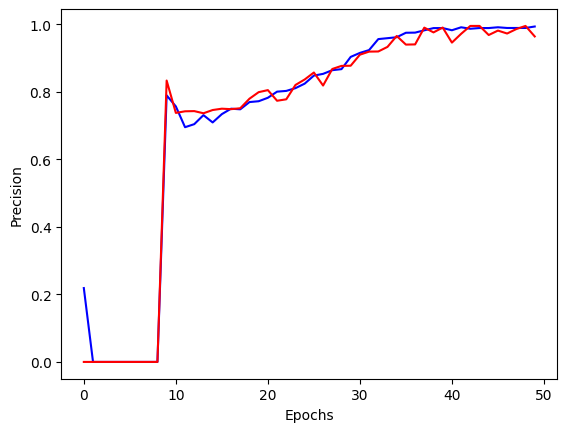

In [46]:
plt.plot(history_embed.history["precision_embed"], color="b")
plt.plot(history_embed.history["val_precision_embed"], color="r")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.show()

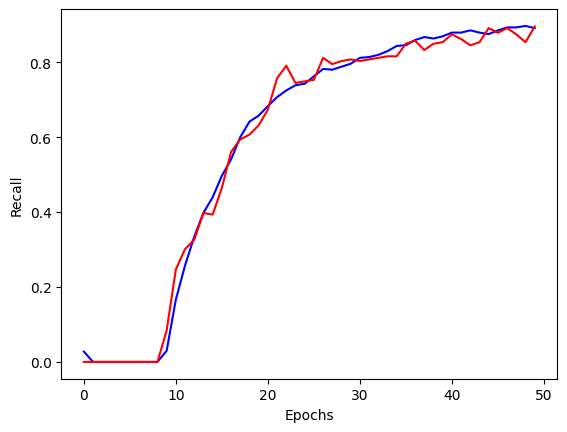

In [47]:
plt.plot(history_embed.history["recall_embed"], color="b")
plt.plot(history_embed.history["val_recall_embed"], color="r")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.show()

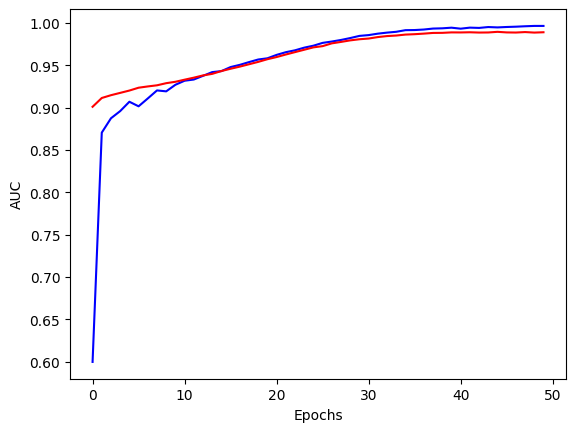

In [48]:
plt.plot(history_embed.history["auc_embed"], color="b")
plt.plot(history_embed.history["val_auc_embed"], color="r")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.show()

## Prédictions

In [49]:
test_pad.shape

(6, 19)

In [50]:
train_pad.shape[1]

74

In [51]:
new_text_padded = tf.keras.preprocessing.sequence.pad_sequences(test_pad, padding="post", maxlen=train_pad.shape[1])

# Prédiction
pred = model_embed.predict(new_text_padded)

for i in range(6):
  print("pred:", pred[i])
  print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
pred: [0.99836665]


pred: [0.98564094]


pred: [0.9966229]


pred: [0.053982]


pred: [0.2569616]


pred: [0.02612114]




Pour rappel, la target était :

In [52]:
sms_test.target

,target
5547,spam
5566,spam
5567,spam
5569,ham
5570,ham
5571,ham


On observe donc une bonne prédiction sur cet ensemble de test.